<a href="https://colab.research.google.com/github/seongheechoi/education/blob/main/01_Word_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

# Representing Words

**워드 임베딩(Word Embedding)**은 자연어처리(NLP)에서 기계가 자연어를 이해할 수 있도록 수치화하여 단어들의 의미를 표현해주는 방식입니다.

일반적으로 비슷한 context에서 사용된 단어는 유사한 의미를 가지는 경향이 있습니다. 워드 임베딩은 이러한 아이디어를 바탕으로 비슷한 컨텍스트를 공유하는 단어는 다차원의 벡터 의미 공간 안에서 비슷한 위치에 표현하도록 하는 것입니다. 즉, 쉽게 말하면, 유사한 단어는 유사한 벡터를 지닌다는 의미입니다.

그렇다면 어떻게 '단어'를 벡터로 만들까요? 우선, 가지고 있는 데이터를 적절하게 전처리하는 과정에 대해 먼저 실습해보겠습니다.


## 1) Text Preprocessing

딥러닝으로 자연어 처리를 해 봅시다. 이때, 가지고 있는 텍스트 데이터를 풀고자 하는 문제의 용도에 맞게 사전에 처리하지 않으면, 이후의 자연어 처리 기법들이 제대로 동작하지 않을 수 있습니다. 이러한 사전 처리 과정을 **텍스트 전처리 (Text Preprocessing)**라고 합니다.

아래의 예시 Corpus부터 시작해 봅시다.

In [ ]:
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',
]


### Word Tokenization

주어진 코퍼스(corpus)에서 토큰(token)이라 불리는 단위로 나누는 작업을 토큰화(tokenization)라고 합니다. 토큰의 단위가 상황에 따라 다르지만, 보통 의미있는 단위로 토큰을 정의합니다. 만약 토큰의 기준을 단어(word)로 하는 경우, **단어 토큰화(word tokenization)**라고 합니다.

영어는 참 간편하게도, 띄어쓰기 단위로 단어가 분리됩니다. 문장을 단어로 쪼개 보겠습니다

In [ ]:
def tokenize_corpus(corpus):  # corpus를 띄어쓰기 단위로 분리하는 함수
    tokens = [x.split() for x in corpus]
    return tokens

In [ ]:
tokenized_corpus = tokenize_corpus(corpus)
print(tokenized_corpus)

[['he', 'is', 'a', 'king'], ['she', 'is', 'a', 'queen'], ['he', 'is', 'a', 'man'], ['she', 'is', 'a', 'woman'], ['warsaw', 'is', 'poland', 'capital'], ['berlin', 'is', 'germany', 'capital'], ['paris', 'is', 'france', 'capital']]


중복된 단어들이 보입니다. 이들을 전부 모아 하나의 'vocabulary' 로 관리하도록 하겠습니다.

In [ ]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)
print(vocabulary)


['he', 'is', 'a', 'king', 'she', 'queen', 'man', 'woman', 'warsaw', 'poland', 'capital', 'berlin', 'germany', 'paris', 'france']


### Integer Encoding

컴퓨터는 텍스트보다는 숫자를 더 잘 처리 할 수 있습니다. 이를 위해 자연어 처리에서는 **텍스트를 숫자로 바꾸는 여러가지 기법**들이 있습니다. 그리고 이러한 기법들을 본격적으로 적용시키기 위한 첫 단계로 **각 단어를 고유한 정수에 맵핑(mapping)**시키는 전처리 작업이 필요합니다.

예를 들어 갖고 있는 텍스트에 단어가 5,000개가 있다면, 5,000개의 단어들 각각에 1번부터 5,000번까지 단어와 맵핑되는 고유한 정수. 다른 표현으로는 인덱스를 부여합니다.

In [ ]:
word2idx = {w: idx for (idx, w) in enumerate(vocabulary)} # key=단어, value=인덱스
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)} # key=인덱스, value=단어

vocabulary_size = len(vocabulary)
print("Total vocabulary size:", vocabulary_size)

Total vocabulary size: 15


In [ ]:
print("Word2Idx (단어: 인덱스)")
print(word2idx)

Word2Idx (단어: 인덱스)
{'he': 0, 'is': 1, 'a': 2, 'king': 3, 'she': 4, 'queen': 5, 'man': 6, 'woman': 7, 'warsaw': 8, 'poland': 9, 'capital': 10, 'berlin': 11, 'germany': 12, 'paris': 13, 'france': 14}


In [ ]:
print("Idx2Word (인덱스: 단어)")
print(idx2word)

Idx2Word (인덱스: 단어)
{0: 'he', 1: 'is', 2: 'a', 3: 'king', 4: 'she', 5: 'queen', 6: 'man', 7: 'woman', 8: 'warsaw', 9: 'poland', 10: 'capital', 11: 'berlin', 12: 'germany', 13: 'paris', 14: 'france'}


## 2) Sparse Representation


### One-Hot Vector

자연어 처리에서는 문자를 숫자로 바꾸는 여러가지 기법 중 **원-핫 인코딩(One-Hot Encoding)**은 단어를 표현하는 가장 기본적인 표현 방법입니다.

원-핫 인코딩을 위해서 먼저 해야할 일은 **단어 집합(vocabulary)**을 만드는 일입니다. 텍스트의 모든 단어를 중복을 허용하지 않고 모아놓으면 이를 단어 집합이라고 합니다. 그리고 이 단어 집합에 고유한 정수를 부여하는 **정수 인코딩(Interger Encoding)**을 진행합니다. 우리는 이 과정을 이미 앞에서 진행했습니다.

원-핫 인코딩은 vocabulary의 크기를 벡터의 차원으로 하고, **표현하고 싶은 단어의 인덱스에 1의 값을 부여하고, 다른 인덱스에는 0을 부여**하는 단어의 벡터 표현 방식입니다. 이렇게 표현된 벡터를 **원-핫 벡터(One-Hot vector)**라고 합니다.

예를 들어, `he` 같은 단어는 [1,0,0,0, ... ,0] 과 같은 one hot 벡터로 나타낼수 있습니다. 이렇게 벡터 또는 행렬(matrix)의 값이 대부분이 0으로 표현되는 방법을 **희소 표현(sparse representation)**이라고 합니다.

In [ ]:
def one_hot_vector(word_idx): # word를 one-hot vector로 바꾸는 함수
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [ ]:
word = "he"
word_idx = word2idx[word]
one_hot_he = one_hot_vector(word_idx)

print(one_hot_he)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


One-hot 은 0 과 1만을 사용하여 간단합니다. 그러나 이러한 희소 벡터의 문제점은 **단어의 개수가 늘어나면 벡터의 차원이 한없이 커진다**는 점입니다. 예를 들어, 코퍼스에 단어가 10,000개였다면 벡터의 차원은 10,000이어야만 하고, 그 중에서 단어의 인덱스에 해당되는 부분만 1이고 나머지는 0의 값을 가집니다.

또한, **단어의 의미를 표현하지 못한다**는 문제점도 가지고 있습니다.

## 3) Dense Representation
밀집 표현은 벡터의 차원을 단어 집합의 크기로 상정하지 않습니다. **사용자가 설정한 값으로 모든 단어의 벡터 표현의 차원을 맞춥니다.**

또한, 이 과정에서 더 이상 0과 1만 가진 값이 아니라 **실수값**을 가지게 됩니다. 이를 통해, 정보량을 유지하면서도 길이를 줄일 수 있습니다.

예를 들어, he = [0.4, 0.7, ... 0.2]와 같이 나타낼 수 있고, 이렇게 대부분의 값이 0이 아닌 값으로 표현되는 벡터나 행렬을 **밀집 표현(dense representation)**이라고 합니다.



### Embedding Vector
단어를 밀집 벡터(dense vector)의 형태로 표현하는 방법을 **워드 임베딩(word embedding)**이라고 합니다. 그리고 이 밀집 벡터를 워드 임베딩 과정을 통해 나온 결과라고 하여 **임베딩 벡터(embedding vector)**라고도 합니다.

Dense Representation 을 사용해야 하는 이유는, 물론 크기가 더 작아 효율적인 측면도 있지만, **단어의 의미를 반영하여 단어 간 유사도를 구할 수 있기 때문**입니다.

# Word Embedding

그렇다면 무엇을 기준으로 vector 를 만들어야 할까요?

실제 NLP 에서 제일 중요하게 생각하는 것은, **단어 간 유사도**입니다.
dog 나 pet 같은 단어들은 의미가 비슷합니다. 따라서, 인코딩을 했을 때 '유사도' 에 대한 정보를 담아야 합니다.


단어를 인코딩시키는 함수 W를 생각해 봅시다.

W('woman') - W('man') $\approx$ W('queen') - W('king')

다음과 같은 규칙을 가질수 있다면, W는 굉장히 좋은 인코딩 함수입니다

또한, 다음의 기능을 할 수도 있으면 정말 좋을것 같네요

W('Nation') $\approx$ W('Korea') - W('Seoul')

이렇게 W를 통해 단어를 벡터로 '잘' 바꾸는 것을 word embedding 이라고 합니다.



한글 Word2Vec:
http://w.elnn.kr/search/


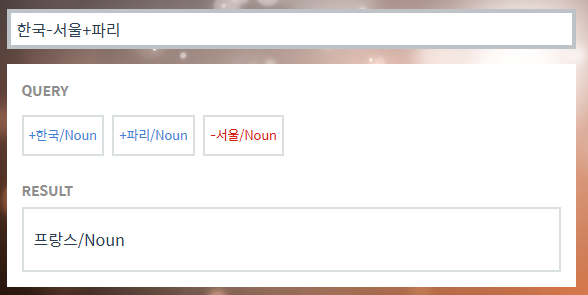

그렇다면 이 W를 어떻게 구할까요?

우리는 이러한 task 를 매우 잘 하는 프로그램을 이미 알고 있습니다. 바로 DNN이죠.

Word2vec의 학습과정을 시각화한 링크:
https://ronxin.github.io/wevi/



## 1) word2vec
이어서 대표적인 word embedding 중 word2vec 에 대하여 설명하겠습니다

우리는 단어간의 유사도를 표현해야 합니다.

그렇다면 이 정보를 어떻게 구할수 있을까요?


답은 문장의 '맥락' 속에 있습니다. 따라서, 빈칸에 어떤 단어가 들어가야하는지 유추하면서 모델을 학습시킬수 있습니다.

문장의 맥락 또한 여러가지가 있습니다.

1. You ___ goodbye and I say hello. -> CBOW

2. ___ say ___  -> Skip-Gram

(참고로, 여러 논문에서 성능 비교를 진행했을 때 전반적으로 Skip-gram이 CBOW보다 성능이 좋다고 알려져 있습니다.)

### CBOW
 예측해야하는 단어를 **중심 단어(center word)**라고 하고, 예측에 사용되는 단어들을 **주변 단어(context word)**라고 합니다. 중심 단어를 예측하기 위해서 앞, 뒤로 몇 개의 단어를 볼지를 결정해야 하는데 이 범위를 **윈도우(window)**라고 합니다. **윈도우 크기(window size)가 n이라고 한다면, 실제 중심 단어를 예측하기 위해 참고하려고 하는 주변 단어의 개수는 2n**입니다.

 아래 그림은 window size = 2인 경우, 슬라이딩 윈도우가 어떤 식으로 이루어지면서 데이터 셋을 만드는지 보여줍니다.



<div>
<img src=https://i.imgur.com/8zNRwsn.png with="500"/>
</div

In [ ]:
window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs)


In [ ]:
print(idx_pairs[:10])

[[0 1]
 [0 2]
 [1 0]
 [1 2]
 [1 3]
 [2 0]
 [2 1]
 [2 3]
 [3 1]
 [3 2]]



<div>
<img src=https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F2Qj2I%2Fbtrb7zSiErG%2FfxZChADnf1iQ7zCx43W5o0%2Fimg.png width="500">
</div>

<div>
<img src=https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbALgGX%2Fbtrb83yAU6c%2FBEqtjlopdhVwR2h6OmzboK%2Fimg.png width="500">
</div>

사실 이 그림에 재미있는 함정이 숨어있는데, 바로 v 만이 임베딩을 하는 W가 아니라는 점 입니다.

u 또한 W로서의 기능을 수행할 수 있습니다.

일반적으로 v 나 u 모두 사용이 가능하며, 때론 두 벡터의 평균을 사용하기도 합니다

In [ ]:
embedding_dims = 5 # 각 단어 벡터의 차원

D, V = embedding_dims, vocabulary_size

# hidden layer
W1 = torch.randn(D, V, requires_grad=True)
# output layer
W2 = torch.randn(V, D, requires_grad=True)

num_epochs = 100
learning_rate = 0.001

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        # one-hot: shape (V,)
        x = one_hot_vector(data).float()
        y_true = torch.tensor([target], dtype=torch.long) # make it long in order to apply log_softmax

        z1 = W1 @ x   # (D,)
        z2 = W2 @ z1   # (V,)

        # log_softmax + nll_loss
        loss = F.cross_entropy(z2.unsqueeze(0), y_true)
        loss_val += loss.data

        loss.backward()

        with torch.no_grad():
            # 가중치 업데이트
            W1 -= learning_rate * W1.grad
            W2 -= learning_rate * W2.grad

            # Gradient 초기화
            W1.grad.zero_()
            W2.grad.zero_()

    if epo % 10 == 0:
        print(f'Loss at epoch {epo}: {loss_val/len(idx_pairs)}')

Loss at epoch 0: 4.039266586303711
Loss at epoch 10: 3.740920066833496
Loss at epoch 20: 3.523824453353882
Loss at epoch 30: 3.355302095413208
Loss at epoch 40: 3.219723701477051
Loss at epoch 50: 3.1077206134796143
Loss at epoch 60: 3.013176441192627
Loss at epoch 70: 2.931994915008545
Loss at epoch 80: 2.8613662719726562
Loss at epoch 90: 2.7992725372314453


In [ ]:
def most_similar(query_word, W1, word2idx, idx2word, topk=3):
  if query_word not in word2idx:
    raise KeyError(f"'{query_word}' not in vocabulary.")

  with torch.no_grad():
      E = F.normalize(W1, dim=0)
  q_idx = word2idx[query_word]
  q_vec = E[:, q_idx]
  sims = torch.mv(E.t(), q_vec)
  vals, inds = sims.topk(topk + 1)  # 자기 자신 제외 위해 +1

  out = []
  for s, i in zip(vals.tolist(), inds.tolist()):
      if i == q_idx:
          continue
      out.append((idx2word[i], float(s)))
      if len(out) == topk:
          break
  return out

In [ ]:
test_word = "capital"
print(f"Similar to '{test_word}': {most_similar(test_word, W1, word2idx, idx2word)}")

Similar to 'capital': [('france', 0.4380287528038025), ('man', 0.38437360525131226), ('poland', 0.3305112421512604)]


**Going Further...**

유사도만 표현해도 될까요? 사실 그게 대부분이긴 하지만, 단어의 등장 빈도 또한 중요한 정보입니다.

vocabulary의 사이즈가 굉장히 크기 떄문에 word2vec 은 무거운 작업입니다. 큰 dimension 은 모든 데이터 scientist 들이 피해야 될 부분이죠.

이러한 면에서 등장 빈도에 따라 생플링을 달리하는게 효과적이기도 합니다.
